In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# Load all locations
files = ['Location1.csv', 'Location2.csv', 'Location3.csv', 'Location4.csv']

dfs = []
for file in files:
    df = pd.read_csv(f'../Data/{file}', parse_dates=['Time'])
    df['Location'] = file.split('.')[0]  # Add location name
    dfs.append(df)

In [5]:
# Combine all locations
data = pd.concat(dfs).sort_values(by=['Time', 'Location'])
data.set_index('Time', inplace=True)

In [6]:
data.head()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,Location
Time,,,,,,,,,,
2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635,Location1
2017-01-02 00:00:00,14.5,91,12.4,6.37,9.58,68,72,9.9,0.2574,Location2
2017-01-02 00:00:00,29.7,55,15.4,4.96,8.46,124,129,8.8,0.3438,Location3
2017-01-02 00:00:00,22.7,82,18.0,3.21,7.60,86,90,5.3,0.3047,Location4
2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424,Location1


In [7]:
import numpy as np
import pandas as pd

# ---- Safe augmentations ---- #

# 1 Jittering: add Gaussian noise
def jitter(series, sigma=0.01):
    noise = np.random.normal(0, sigma, size=series.shape)
    return series + noise

# 2️ Scaling: multiply by small random factor
def scaling(series, factor=0.05):
    scale = np.random.uniform(1 - factor, 1 + factor)
    return series * scale

# 3️ Drift (slow trend addition)
def drift(series, max_drift=0.02):
    drift = np.linspace(0, np.random.uniform(-max_drift, max_drift), num=len(series))
    return series + drift

# 4️ Magnitude warping (slight non-linear scaling)
def magnitude_warp(series, sigma=0.1):
    from scipy.interpolate import CubicSpline
    random_curve = np.random.normal(1.0, sigma, size=5)
    spline = CubicSpline(np.linspace(0, len(series), num=5), random_curve)
    warp_curve = spline(np.arange(len(series)))
    return series * warp_curve

# -------- Full augmentation function -------- #
def augment_timeseries(df, columns_to_augment, num_augmented_copies=5):
    augmented_data = []

    for i in range(num_augmented_copies):
        df_aug = df.copy()
        for col in columns_to_augment:
            series = df[col].values

            # Apply multiple augmentations
            series_aug = jitter(series, sigma=0.01)
            series_aug = scaling(series_aug, factor=0.03)
            series_aug = drift(series_aug, max_drift=0.01)
            series_aug = magnitude_warp(series_aug, sigma=0.05)

            df_aug[col] = series_aug

        df_aug['augmented'] = i+1
        augmented_data.append(df_aug)

    augmented_full = pd.concat([df] + augmented_data, axis=0).reset_index(drop=True)
    return augmented_full


# Columns to augment
columns_to_augment = ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
                      'windspeed_10m', 'windspeed_100m', 'windgusts_10m']

# Generate augmented dataset (e.g. 5 augmented copies)
augmented_data = augment_timeseries(data, columns_to_augment, num_augmented_copies=5)

print(f"Original samples: {len(data)}, After augmentation: {len(augmented_data)}")


Original samples: 175200, After augmentation: 1051200


In [8]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051200 entries, 0 to 1051199
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   temperature_2m       1051200 non-null  float64
 1   relativehumidity_2m  1051200 non-null  float64
 2   dewpoint_2m          1051200 non-null  float64
 3   windspeed_10m        1051200 non-null  float64
 4   windspeed_100m       1051200 non-null  float64
 5   winddirection_10m    1051200 non-null  int64  
 6   winddirection_100m   1051200 non-null  int64  
 7   windgusts_10m        1051200 non-null  float64
 8   Power                1051200 non-null  float64
 9   Location             1051200 non-null  object 
 10  augmented            876000 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 88.2+ MB


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175200 entries, 2017-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   temperature_2m       175200 non-null  float64
 1   relativehumidity_2m  175200 non-null  int64  
 2   dewpoint_2m          175200 non-null  float64
 3   windspeed_10m        175200 non-null  float64
 4   windspeed_100m       175200 non-null  float64
 5   winddirection_10m    175200 non-null  int64  
 6   winddirection_100m   175200 non-null  int64  
 7   windgusts_10m        175200 non-null  float64
 8   Power                175200 non-null  float64
 9   Location             175200 non-null  object 
dtypes: float64(6), int64(3), object(1)
memory usage: 14.7+ MB


In [10]:
# First assign 0 to original data
data['augmented'] = 0

# Apply augmentation again (but avoid double counting original this time)
augmented_data = augment_timeseries(data, columns_to_augment, num_augmented_copies=5)

# Restore DatetimeIndex
augmented_data['Timestamp'] = pd.date_range(start='2017-01-02 00:00:00', periods=len(augmented_data), freq='H')
augmented_data = augmented_data.set_index('Timestamp')

/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_6297/2819438302.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  augmented_data['Timestamp'] = pd.date_range(start='2017-01-02 00:00:00', periods=len(augmented_data), freq='H')


In [11]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1051200 entries, 2017-01-02 00:00:00 to 2136-12-03 23:00:00
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   temperature_2m       1051200 non-null  float64
 1   relativehumidity_2m  1051200 non-null  float64
 2   dewpoint_2m          1051200 non-null  float64
 3   windspeed_10m        1051200 non-null  float64
 4   windspeed_100m       1051200 non-null  float64
 5   winddirection_10m    1051200 non-null  int64  
 6   winddirection_100m   1051200 non-null  int64  
 7   windgusts_10m        1051200 non-null  float64
 8   Power                1051200 non-null  float64
 9   Location             1051200 non-null  object 
 10  augmented            1051200 non-null  int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 96.2+ MB


In [12]:
# Suppose you originally started with this
original_data = data.copy()
original_data['augmented'] = 0

# Do augmentation (without resetting index)
augmented_copies = []
for i in range(5):
    df_aug = original_data.copy()
    for col in columns_to_augment:
        series = df_aug[col].values
        series_aug = jitter(series, sigma=0.01)
        series_aug = scaling(series_aug, factor=0.03)
        series_aug = drift(series_aug, max_drift=0.01)
        series_aug = magnitude_warp(series_aug, sigma=0.05)
        df_aug[col] = series_aug

    df_aug['augmented'] = i+1
    augmented_copies.append(df_aug)

# Concatenate: original + augmented (all having same timestamps)
augmented_data = pd.concat([original_data] + augmented_copies, axis=0)
augmented_data = augmented_data.sort_index()


In [13]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1051200 entries, 2017-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   temperature_2m       1051200 non-null  float64
 1   relativehumidity_2m  1051200 non-null  float64
 2   dewpoint_2m          1051200 non-null  float64
 3   windspeed_10m        1051200 non-null  float64
 4   windspeed_100m       1051200 non-null  float64
 5   winddirection_10m    1051200 non-null  int64  
 6   winddirection_100m   1051200 non-null  int64  
 7   windgusts_10m        1051200 non-null  float64
 8   Power                1051200 non-null  float64
 9   Location             1051200 non-null  object 
 10  augmented            1051200 non-null  int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 96.2+ MB


# EDA (analysis between augmented and orignal data)

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



In [15]:
# General stats
print(data.describe())

# Check class balance (per location)
print(data['Location'].value_counts())

# Check if any null values
print(data.isnull().sum())


       temperature_2m  relativehumidity_2m    dewpoint_2m  windspeed_10m  \
count   175200.000000        175200.000000  175200.000000  175200.000000   
mean        46.655994            70.155291      36.516241       4.157639   
std         22.012738            17.326678      20.933153       2.012682   
min        -31.200000             9.000000     -36.200000       0.000000   
25%         30.200000            57.000000      21.900000       2.630000   
50%         46.900000            72.000000      36.200000       3.850000   
75%         65.300000            84.000000      54.600000       5.380000   
max        101.700000           100.000000      78.700000      18.530000   

       windspeed_100m  winddirection_10m  winddirection_100m  windgusts_10m  \
count   175200.000000      175200.000000       175200.000000  175200.000000   
mean         6.879334         201.589446          201.539070       8.038205   
std          3.043964          99.639040          100.683777       3.617488   

In [16]:
augmented_data[augmented_data['augmented'] != 0]

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,Location,augmented
Time,,,,,,,,,,,
2017-01-02 00:00:00,14.026701,90.545021,12.192426,6.504589,9.273044,68,72,10.573229,0.2574,Location2,2
2017-01-02 00:00:00,27.543895,84.561923,24.100088,1.476550,1.208518,146,162,1.519594,0.1635,Location1,2
2017-01-02 00:00:00,23.001334,85.990119,19.104943,3.230808,7.440449,86,90,5.069655,0.3047,Location4,1
2017-01-02 00:00:00,30.090941,57.669615,16.366289,4.980186,8.283928,124,129,8.371873,0.3438,Location3,1
2017-01-02 00:00:00,14.684308,95.414887,13.178561,6.411192,9.382819,68,72,9.411815,0.2574,Location2,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:00:00,25.605210,91.281008,21.893956,4.721069,7.564419,9,12,8.205985,0.3117,Location4,3
2021-12-31 23:00:00,38.931009,96.661343,33.851374,2.152794,5.035171,45,51,4.462838,0.2877,Location1,4
2021-12-31 23:00:00,-20.335129,70.759020,-24.626415,5.232775,9.632708,302,307,9.167558,0.2609,Location2,4


In [17]:
augmented_data.to_csv('../Data/Augmented_Combined_data.csv')

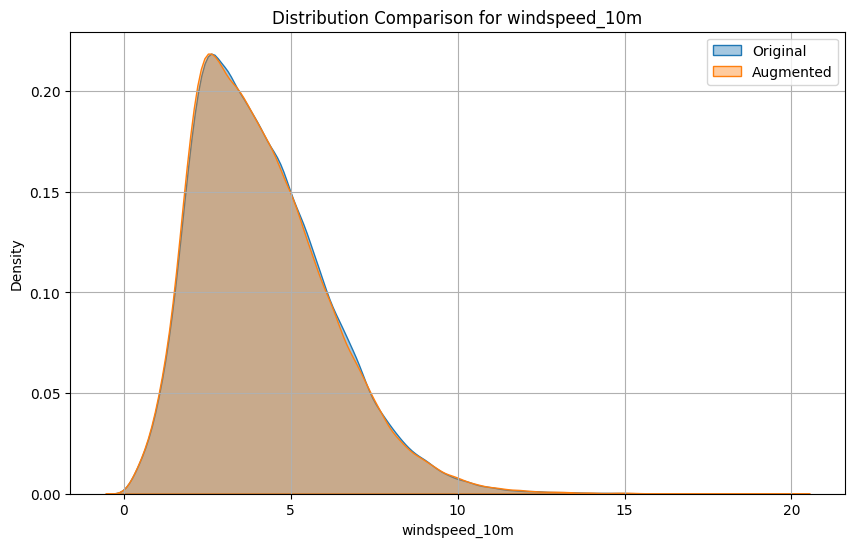

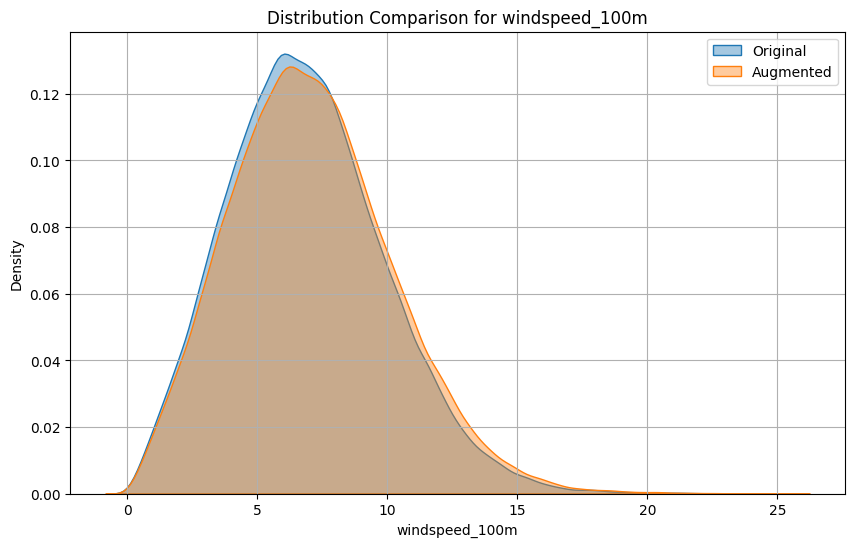

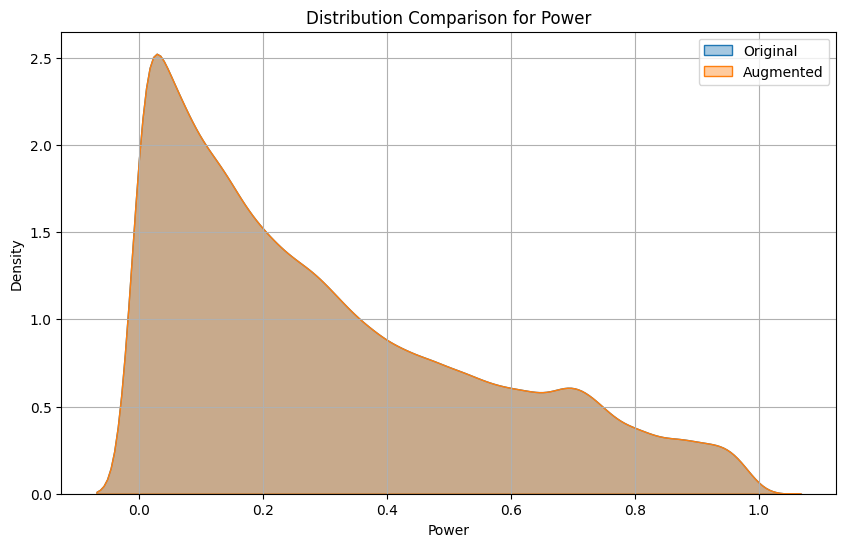

In [18]:
# Separate original and augmented samples
original = augmented_data[augmented_data['augmented'] == 0]
augmented = augmented_data[augmented_data['augmented'] == 1]

# Compare distributions for one key feature
features = ['windspeed_10m', 'windspeed_100m', 'Power']

for feature in features:
    plt.figure(figsize=(10,6))
    sns.kdeplot(original[feature], label='Original', fill=True, alpha=0.4)
    sns.kdeplot(augmented[feature], label='Augmented', fill=True, alpha=0.4)
    plt.title(f'Distribution Comparison for {feature}')
    plt.legend()
    plt.grid()
    plt.show()


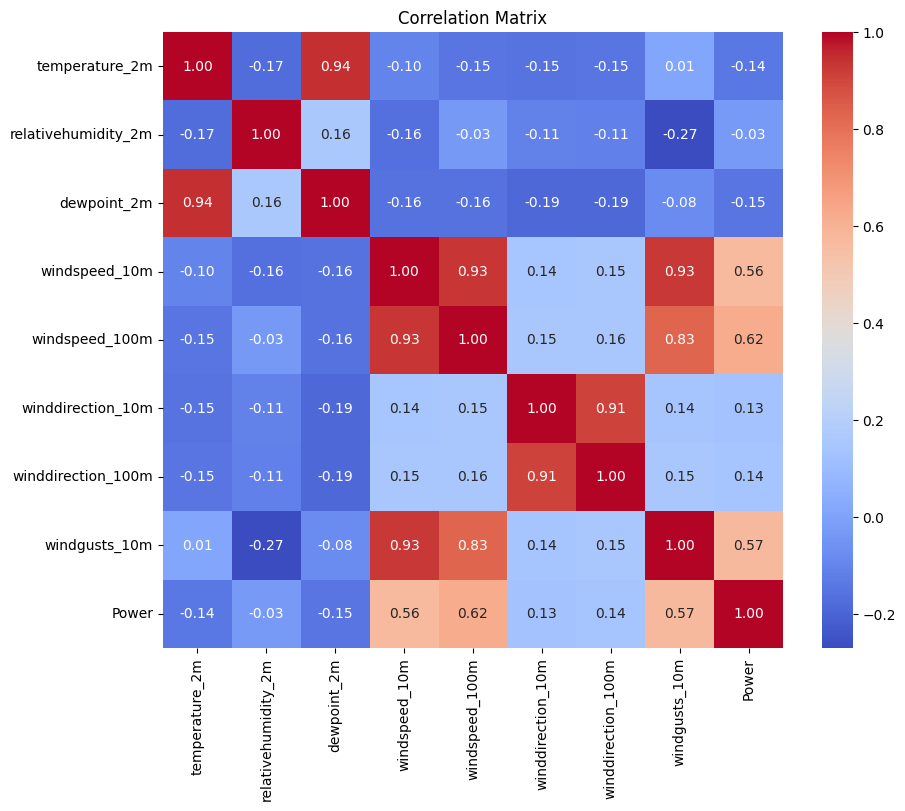

In [19]:
# Only numeric features
numeric_features = data.select_dtypes(include=['float64', 'int64']).drop(columns=['augmented'])

corr = numeric_features.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


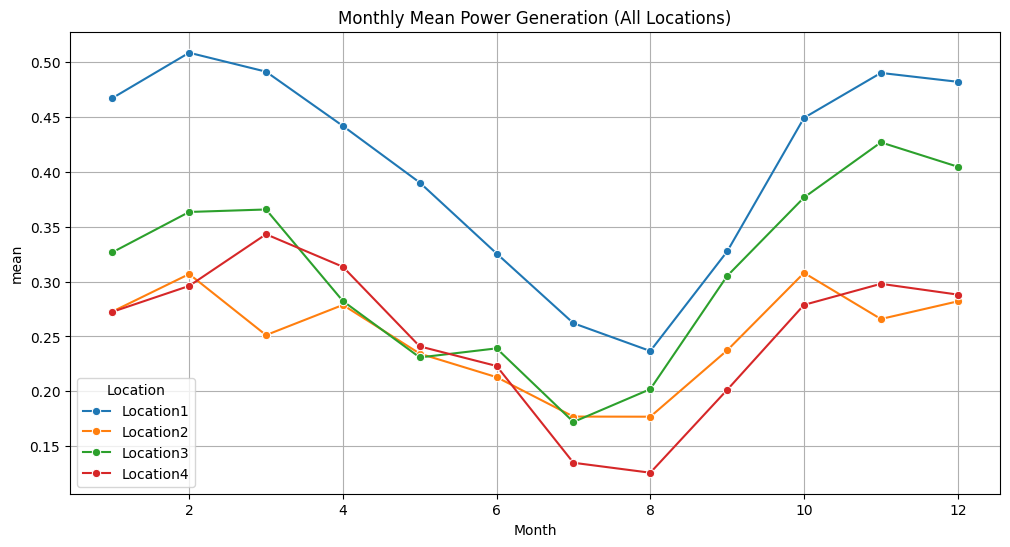

In [20]:
# Extract month
data['Month'] = data.index.month

monthly_stats = data.groupby(['Month', 'Location'])['Power'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_stats, x='Month', y='mean', hue='Location', marker="o")
plt.title("Monthly Mean Power Generation (All Locations)")
plt.grid()
plt.show()

# You can also add std bars later if you want.


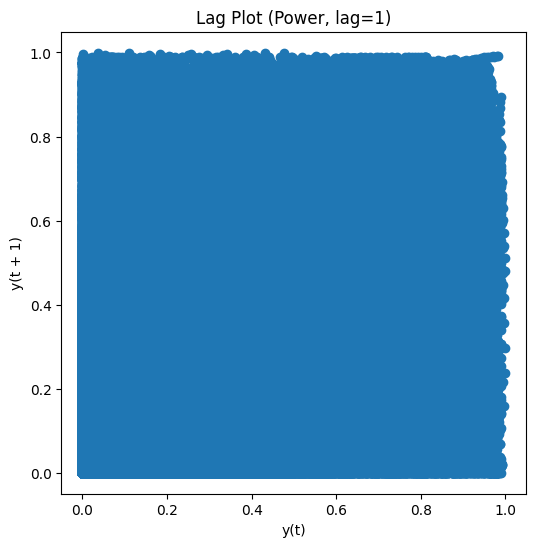

In [21]:
from pandas.plotting import lag_plot

plt.figure(figsize=(6,6))
lag_plot(data['Power'], lag=1)
plt.title('Lag Plot (Power, lag=1)')
plt.show()


In [22]:
import statsmodels.api as sm


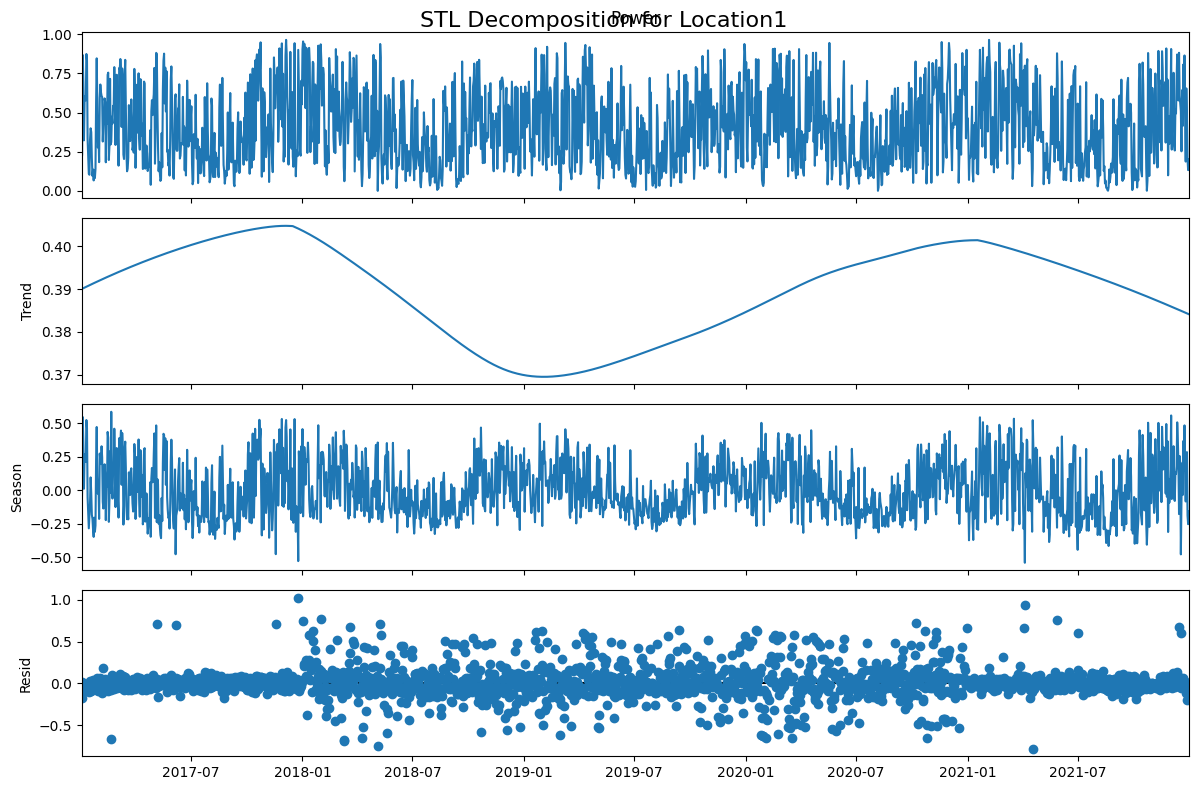

In [23]:
# Select one location
loc = 'Location1'

# Filter data for that location
loc_data = augmented_data[augmented_data['Location'] == loc]

# Keep only numeric columns
numeric_cols = loc_data.select_dtypes(include=['float64', 'int64']).columns

# Resample on daily level (using numeric columns only)
loc_data_daily = loc_data[numeric_cols].resample('D').mean()

# STL decomposition on Power column
stl = sm.tsa.STL(loc_data_daily['Power'], period=365, robust=True)
result_stl = stl.fit()

plt.rcParams.update({'figure.figsize': (12, 8)})
result_stl.plot()
plt.suptitle(f'STL Decomposition for {loc}', fontsize=16)
plt.show()


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import lag_plot, autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')




In [40]:
# Full descriptive stats
desc = augmented_data.describe().T
desc['missing'] = augmented_data.isnull().sum()
print(desc)


                         count        mean         std        min         25%  \
temperature_2m       1051200.0   47.042630   22.454924 -34.900596   30.336551   
relativehumidity_2m  1051200.0   70.272408   17.767975   8.669817   57.183104   
dewpoint_2m          1051200.0   36.909156   21.247371 -38.606137   22.090659   
windspeed_10m        1051200.0    4.067256    1.979574  -0.027713    2.570000   
windspeed_100m       1051200.0    6.888338    3.072130  -0.017357    4.690000   
winddirection_10m    1051200.0  201.589446   99.638803   1.000000  130.000000   
winddirection_100m   1051200.0  201.539070  100.683538   0.000000  129.000000   
windgusts_10m        1051200.0    7.974629    3.602633   0.458175    5.210600   
Power                1051200.0    0.303429    0.257324   0.000000    0.087700   
augmented            1051200.0    2.500000    1.707826   0.000000    1.000000   

                            50%         75%         max  missing  
temperature_2m        47.142449   65.5000

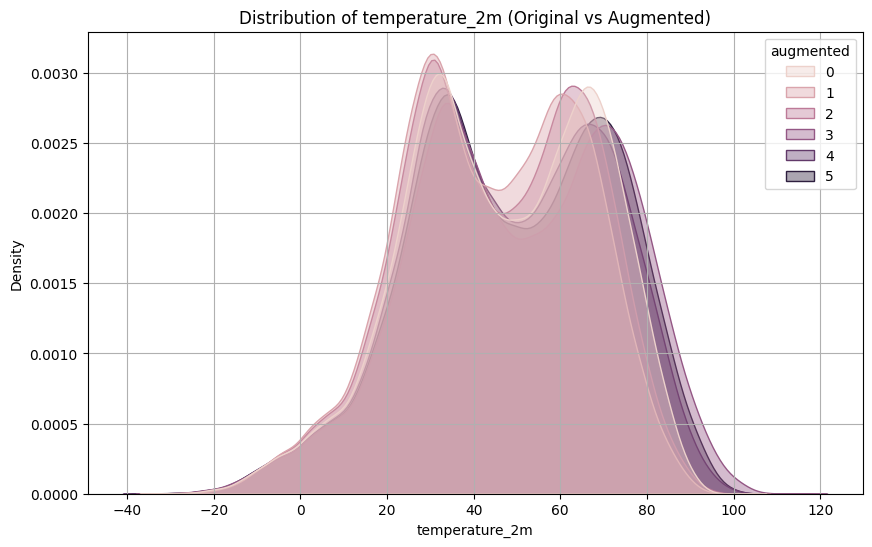

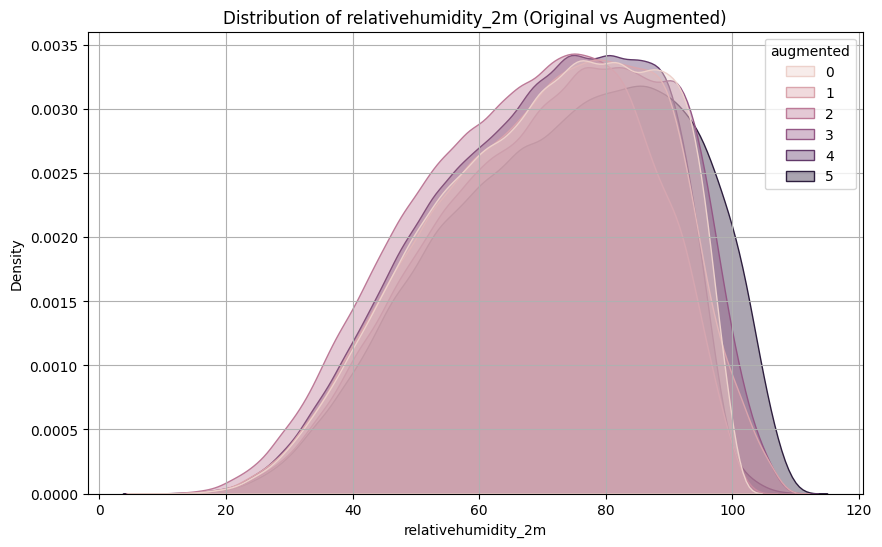

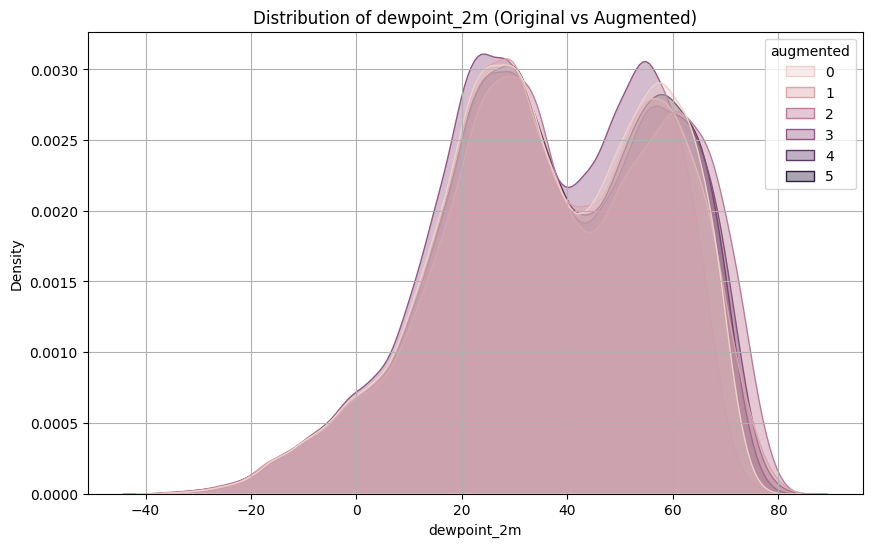

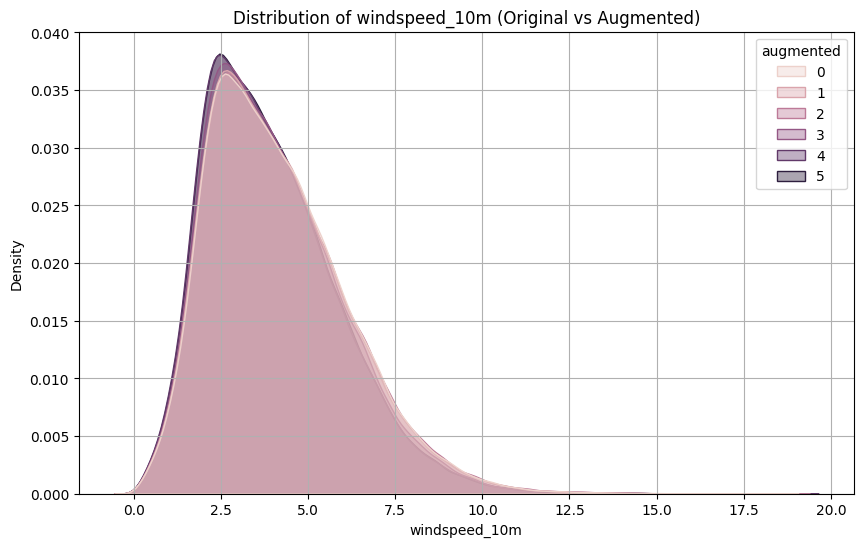

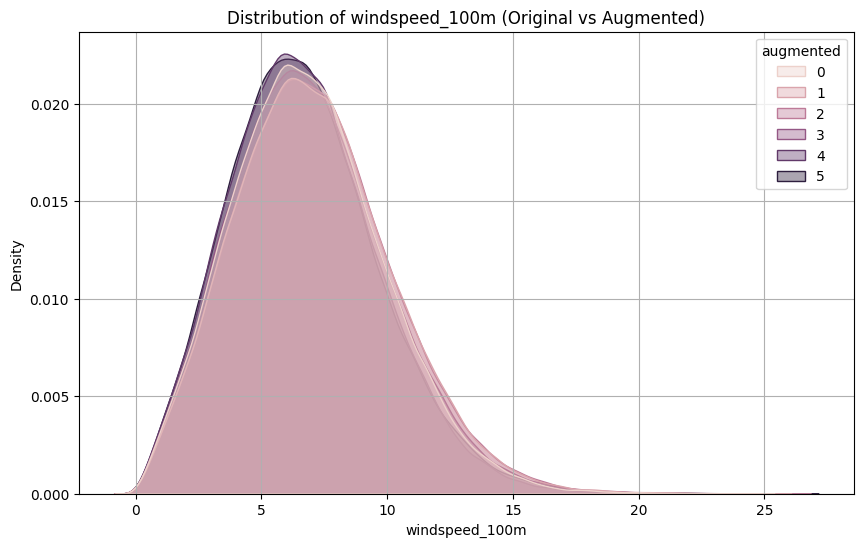

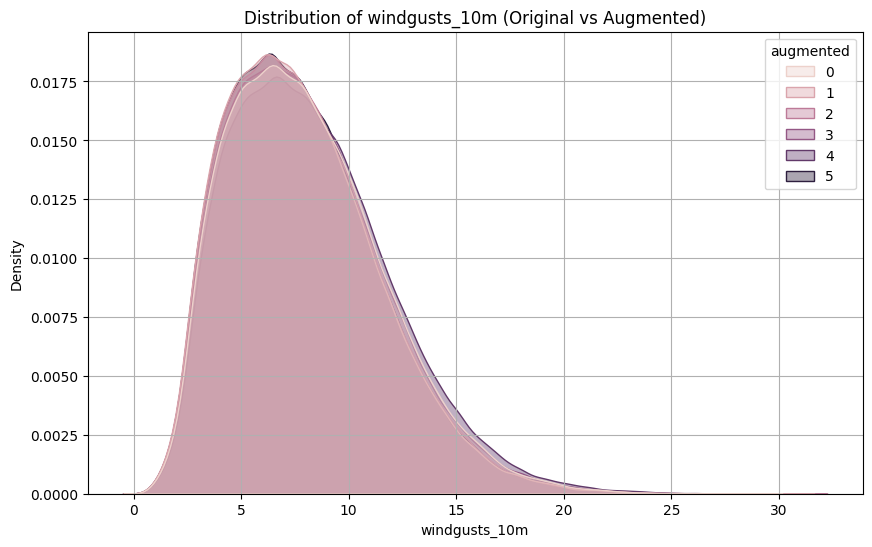

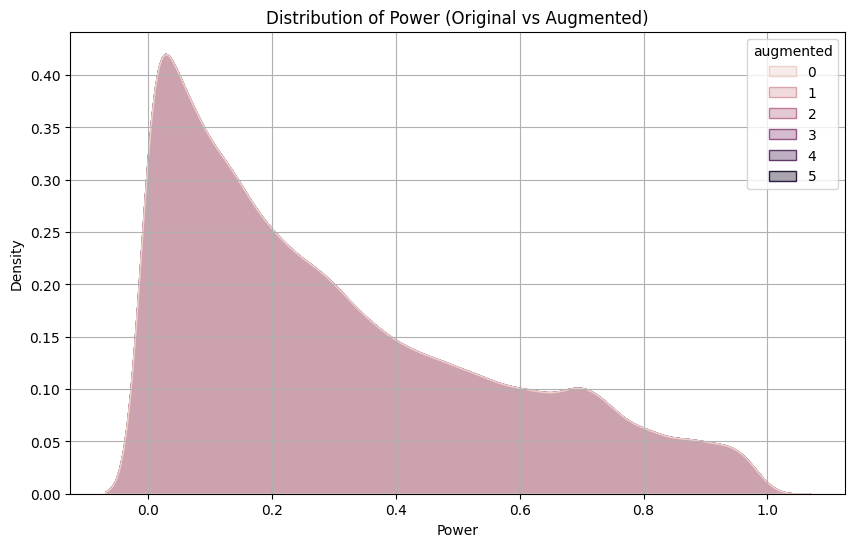

In [44]:
features = ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
            'windspeed_10m', 'windspeed_100m', 'windgusts_10m', 'Power']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=augmented_data, x=feature, hue='augmented', fill=True, alpha=0.4)
    plt.title(f'Distribution of {feature} (Original vs Augmented)')
    plt.grid()
    plt.show()


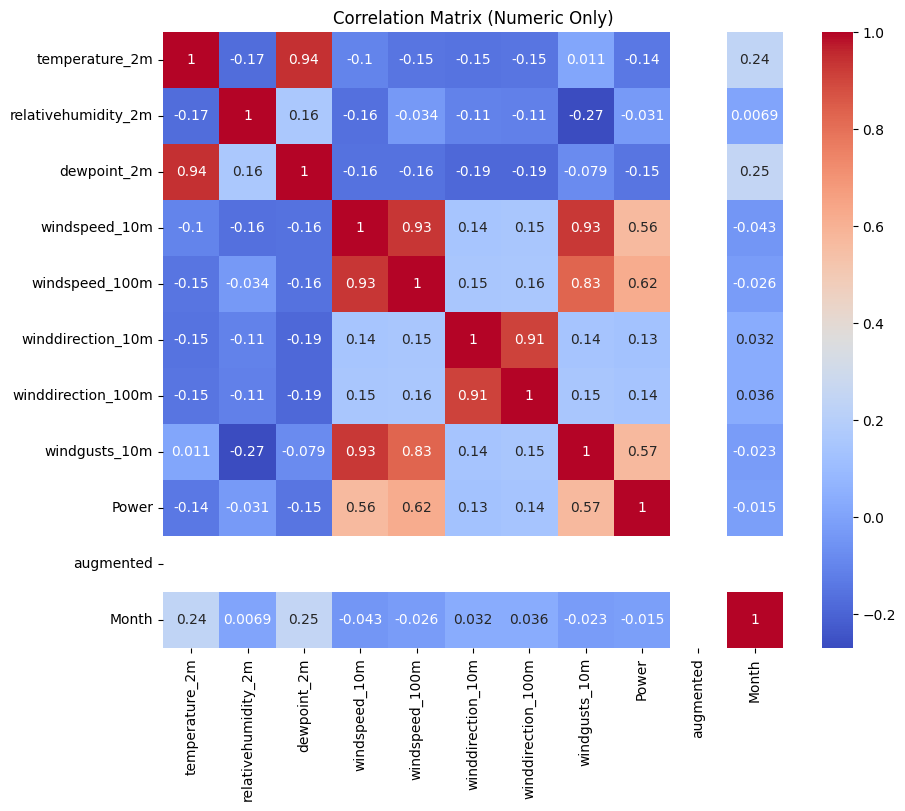

In [62]:
# Only select numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Only)")
plt.show()


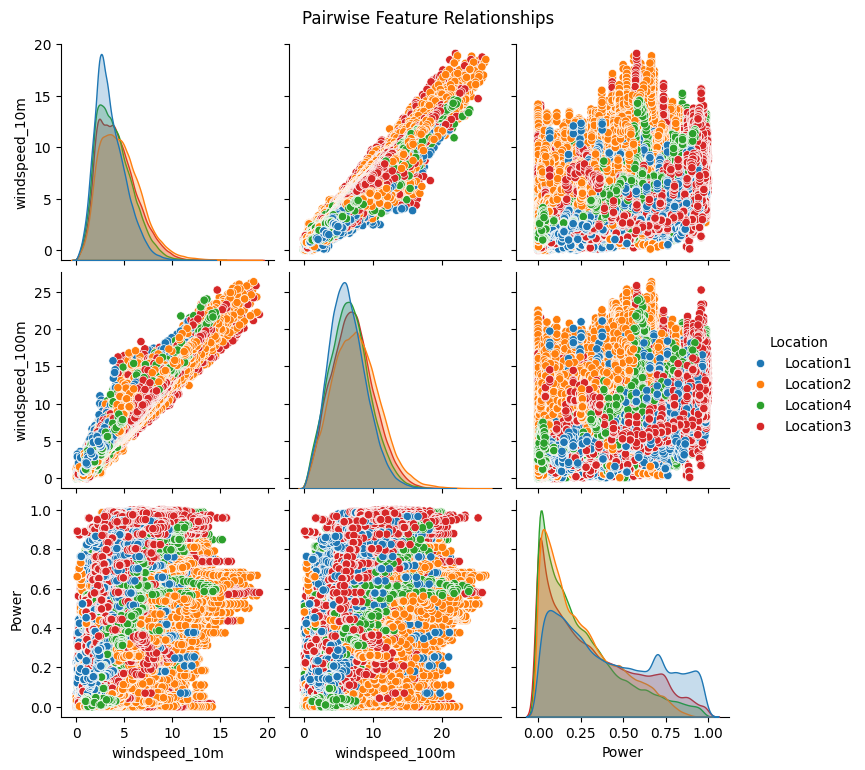

In [53]:
sns.pairplot(data=augmented_data, vars=['windspeed_10m', 'windspeed_100m', 'Power'], hue='Location')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()


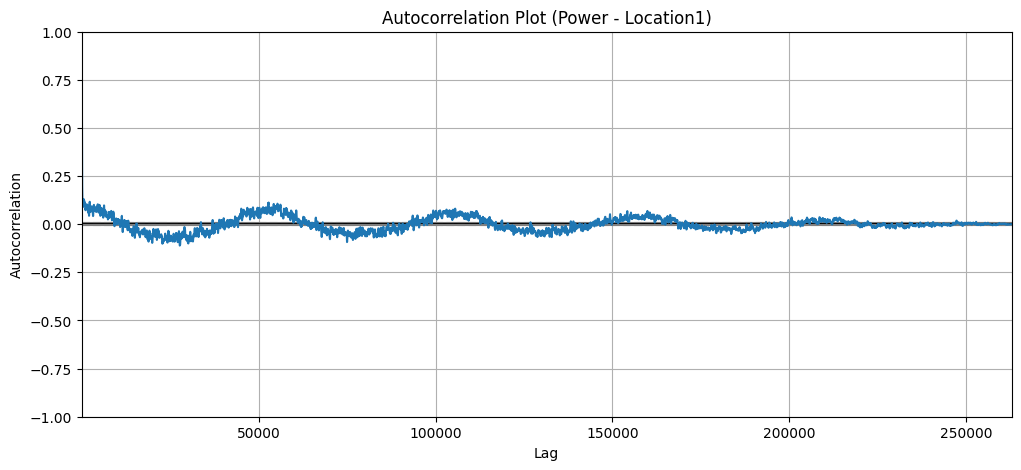

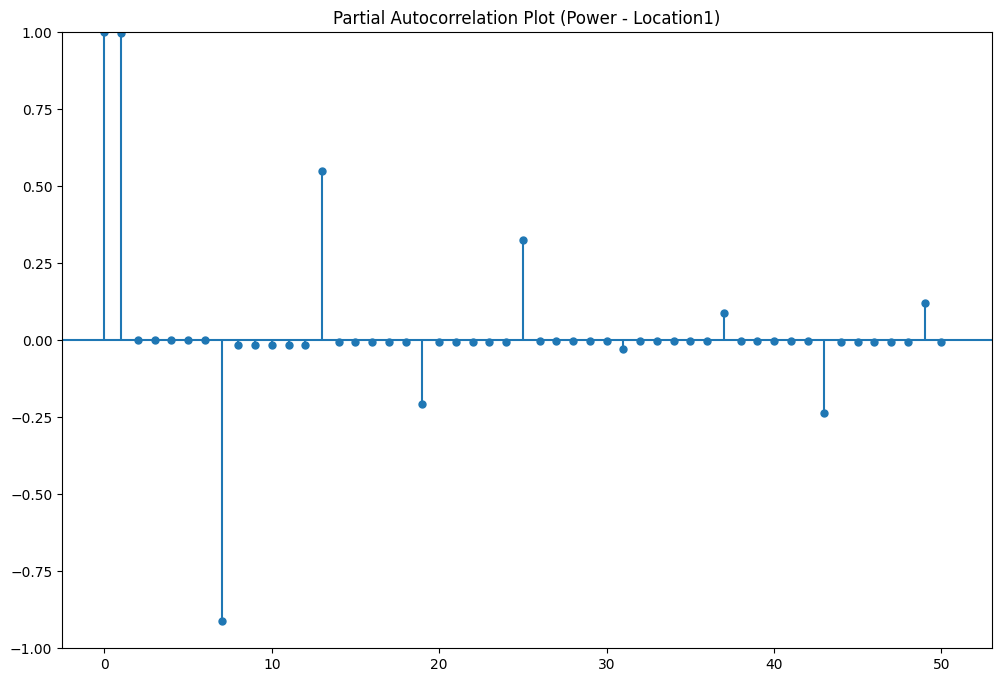

In [59]:
# Select only numeric columns for aggregation
numeric_cols = augmented_data.select_dtypes(include=[np.number]).columns

# Filter one location
loc_data = augmented_data[augmented_data['Location'] == 'Location1']

# Resample numeric data only
loc_data_resampled = loc_data[numeric_cols].resample('D').mean()
# Autocorrelation Plot
plt.figure(figsize=(12,5))
autocorrelation_plot(loc_data['Power'])
plt.title("Autocorrelation Plot (Power - Location1)")
plt.show()

# Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(loc_data['Power'], lags=50)
plt.title("Partial Autocorrelation Plot (Power - Location1)")
plt.show()


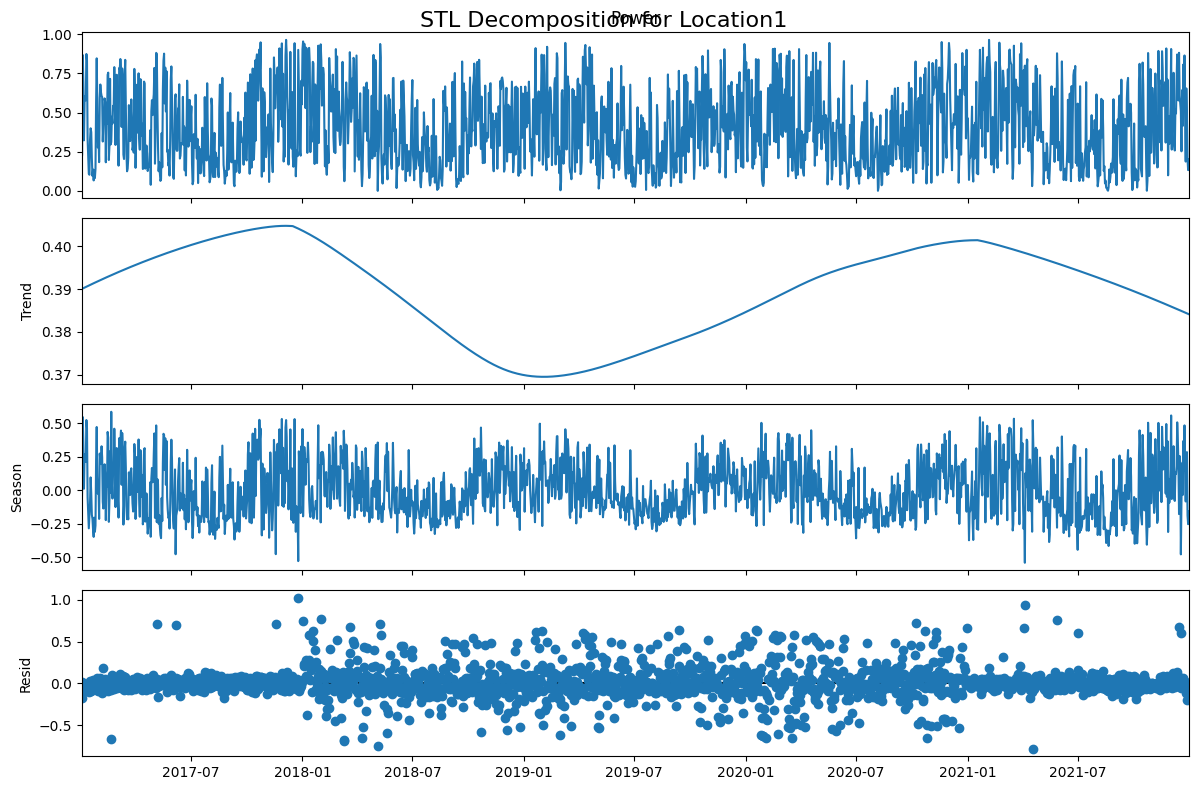

In [58]:
# Select only numeric columns for aggregation
numeric_cols = augmented_data.select_dtypes(include=[np.number]).columns

# Filter one location
loc_data = augmented_data[augmented_data['Location'] == 'Location1']

# Resample numeric data only
loc_data_resampled = loc_data[numeric_cols].resample('D').mean()

# Now proceed safely
stl = sm.tsa.STL(loc_data_resampled['Power'], period=365, robust=True)
result_stl = stl.fit()

plt.rcParams.update({'figure.figsize': (12, 8)})
result_stl.plot()
plt.suptitle(f'STL Decomposition for Location1', fontsize=16)
plt.show()


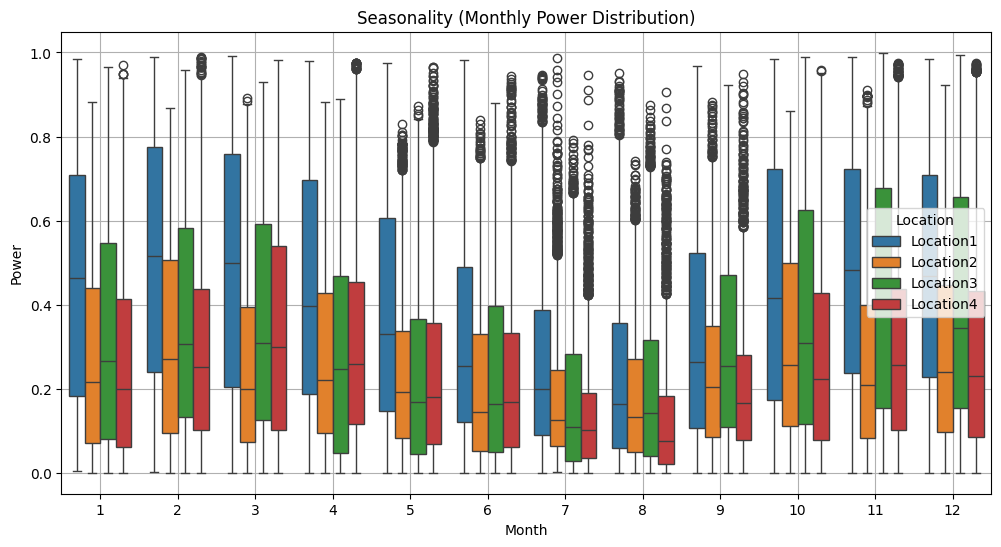

In [65]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Month', y='Power', hue='Location')
plt.title('Seasonality (Monthly Power Distribution)')
plt.grid()
plt.show()


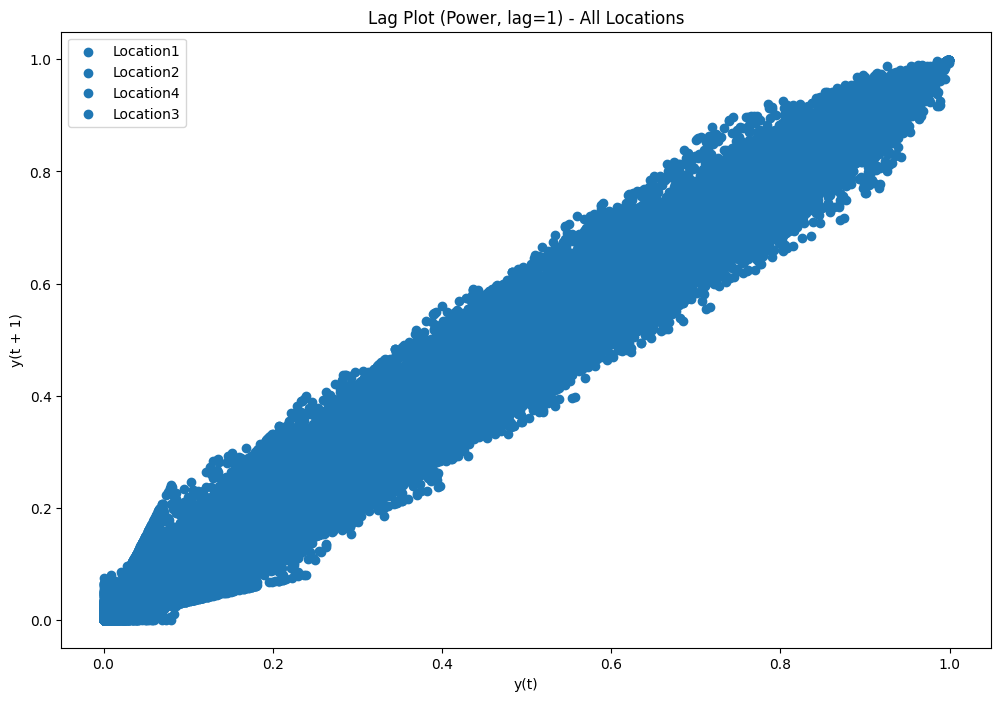

In [67]:
plt.figure(figsize=(12, 8))
for loc in augmented_data['Location'].unique():
    subset = augmented_data[augmented_data['Location'] == loc]
    lag_plot(subset['Power'], lag=1, label=loc)
plt.title("Lag Plot (Power, lag=1) - All Locations")
plt.legend()
plt.show()


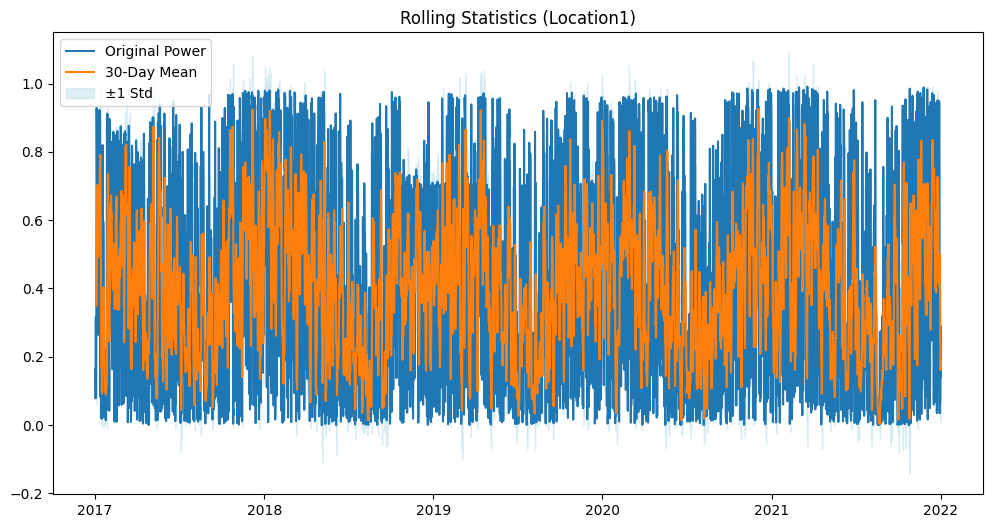

In [70]:
loc_data['rolling_mean'] = loc_data['Power'].rolling(window=365).mean()
loc_data['rolling_std'] = loc_data['Power'].rolling(window=365).std()

plt.figure(figsize=(12, 6))
plt.plot(loc_data['Power'], label='Original Power')
plt.plot(loc_data['rolling_mean'], label='30-Day Mean')
plt.fill_between(loc_data.index, loc_data['rolling_mean']-loc_data['rolling_std'], 
                 loc_data['rolling_mean']+loc_data['rolling_std'], color='lightblue', alpha=0.4, label='±1 Std')
plt.title('Rolling Statistics (Location1)')
plt.legend()
plt.show()
